In [1]:
import os
import cv2

import glob
import numpy as np

import random
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import torch.nn.functional as F

## Torchvision
import torchvision
from torchvision import transforms
import torchvision.transforms as T

from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import accuracy as ACC

import pytorch_lightning as pl

from torchsummary import summary

In [2]:
import torch

def check_gpu():
    if torch.cuda.is_available():
        print("GPU is available.")
        print("GPU Device Name:", torch.cuda.get_device_name(0))  # Get the name of the first GPU device
        print("GPU Device Count:", torch.cuda.device_count())  # Get the number of available GPUs
        print("CUDA Version:", torch.version.cuda)  # Get the installed CUDA version
        print("PyTorch Version:", torch.__version__)  # Get the installed PyTorch version
    else:
        print("GPU is not available. Using CPU.")

if __name__ == "__main__":
    check_gpu()

GPU is available.
GPU Device Name: NVIDIA GeForce RTX 3080 Laptop GPU
GPU Device Count: 1
CUDA Version: 11.8
PyTorch Version: 2.0.1+cu118


In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set the seed for reproducibility
set_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
print(torch.cuda.is_available())

Device: cuda
True


In [4]:
class Load_Preprocess():
    def __init__(self):
               
        self.Train, self.Train_labels, self.Valid, self.Val_labels, self.Test, self.Test_labels  = self.preprocessing('VD_dataset2')
        
    def preprocessing(self, dir_path):
        Images = glob.glob(dir_path + '/*_input.png') #reading the file names in the folder of images
        Labels = glob.glob(dir_path + '/*_target.png')
        
        X_train, X_test, y_train, y_test = train_test_split(Images, Labels, test_size=0.2, random_state = 123)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = 123)
        
        return X_train, y_train, X_val, y_val , X_test, y_test
        
Data = Load_Preprocess()

In [5]:
Data.Train[0:10], Data.Train_labels[0:10]

(['VD_dataset2\\4240_input.png',
  'VD_dataset2\\1832_input.png',
  'VD_dataset2\\4160_input.png',
  'VD_dataset2\\2860_input.png',
  'VD_dataset2\\0124_input.png',
  'VD_dataset2\\1052_input.png',
  'VD_dataset2\\1684_input.png',
  'VD_dataset2\\2840_input.png',
  'VD_dataset2\\2760_input.png',
  'VD_dataset2\\1120_input.png'],
 ['VD_dataset2\\4240_target.png',
  'VD_dataset2\\1832_target.png',
  'VD_dataset2\\4160_target.png',
  'VD_dataset2\\2860_target.png',
  'VD_dataset2\\0124_target.png',
  'VD_dataset2\\1052_target.png',
  'VD_dataset2\\1684_target.png',
  'VD_dataset2\\2840_target.png',
  'VD_dataset2\\2760_target.png',
  'VD_dataset2\\1120_target.png'])

In [6]:
# Print the first few image paths to check if they exist
print("Size of Train set:", len(Data.Train), len(Data.Train_labels))
print("Size of Validation set:", len(Data.Valid), len(Data.Val_labels))
print("Size of Test set:", len(Data.Test), len(Data.Test_labels))

Size of Train set: 965 965
Size of Validation set: 121 121
Size of Test set: 121 121


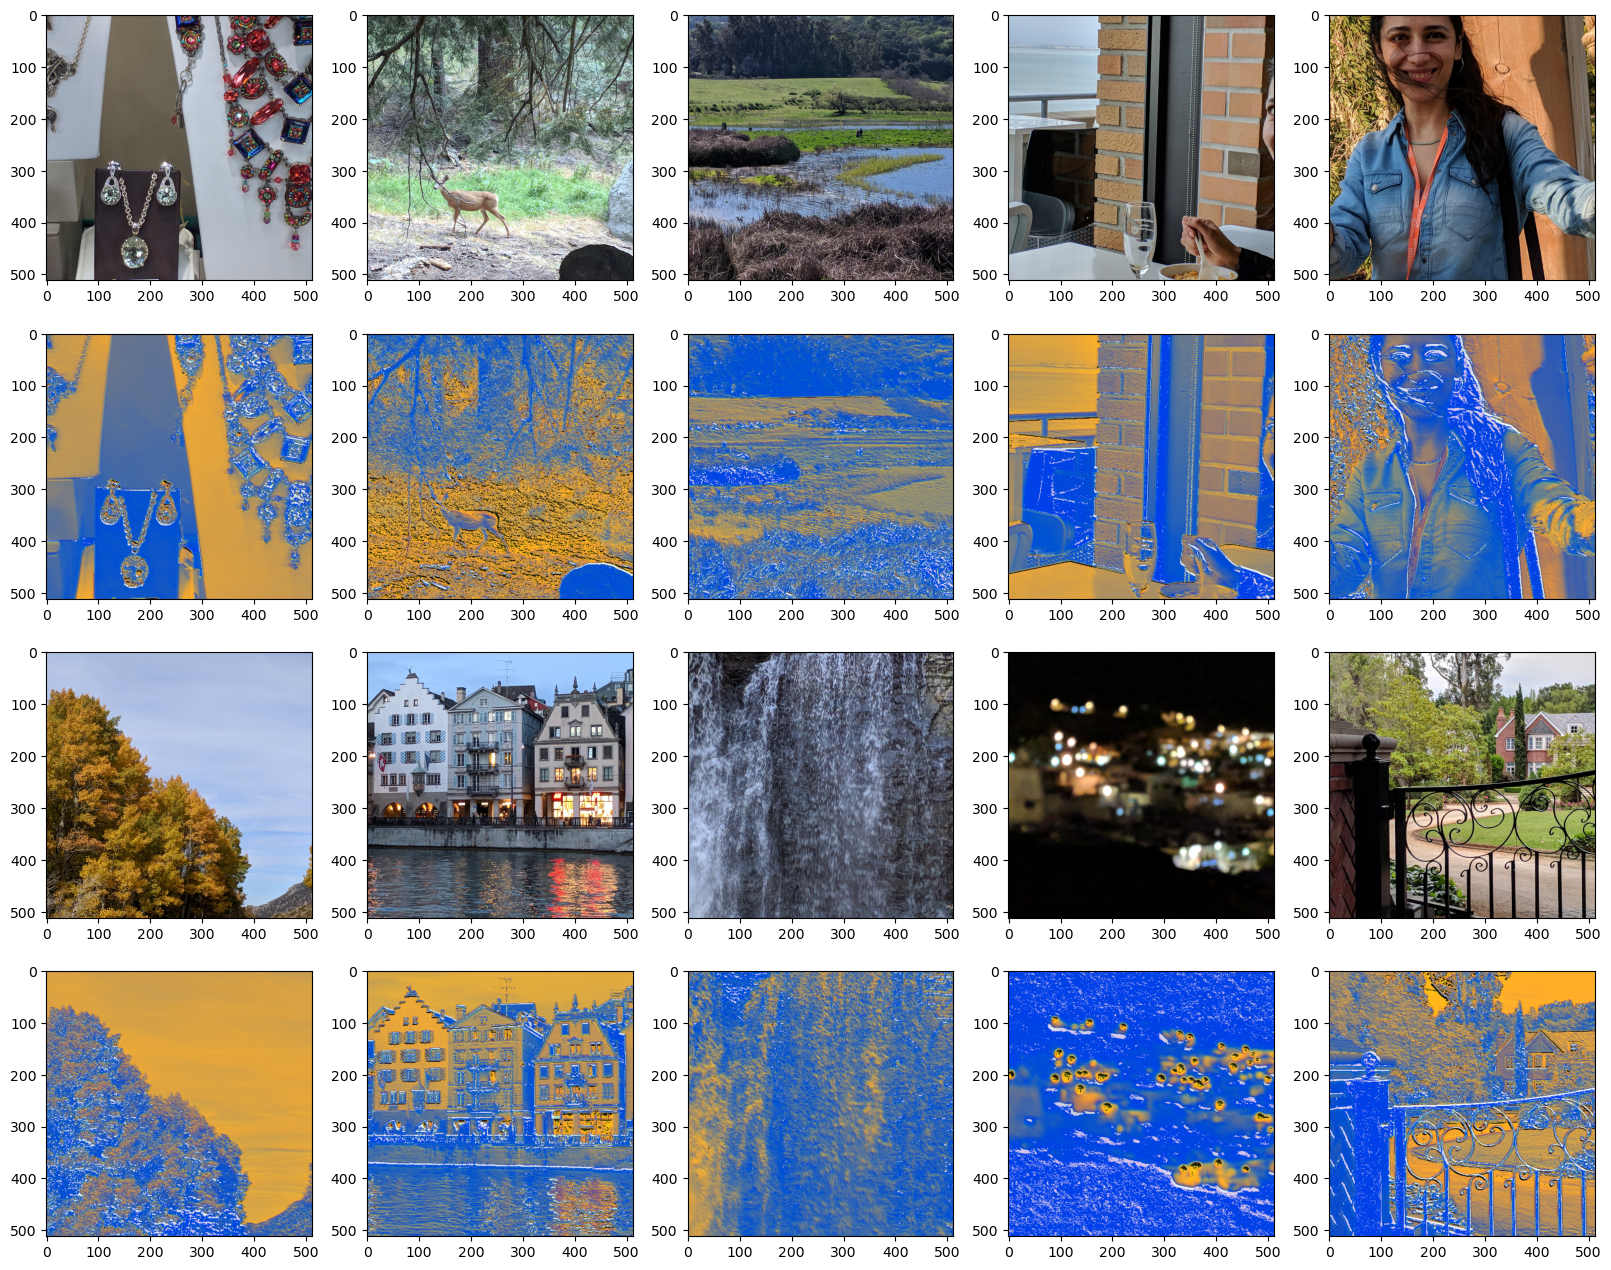

In [7]:
Images = Data.Train[0:5]+ Data.Train_labels[0:5]+Data.Train[5:10]+Data.Train_labels[5:10]

plt.figure(figsize=(20, 20))
files = 20
for i in range(files):
    plt.subplot(5, 5, i+1)
    img = Image.open(Images[i])
    plt.imshow(img)
    
#     plt.axis('off')

# Data generators for augmentation and normalization

In [9]:
transform = T.Compose([transforms.ToPILImage(),
                       transforms.ToTensor()])

class Img2ImgDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.Images = images
        self.Targets = targets
        self.transform = transform
        
    def __len__(self):
        return len(self.Targets)
    def __getitem__(self, idx):
        
#         image = Image.open(self.Images[idx]).convert('RGB')  
#         target = Image.open(self.Targets[idx]).convert('RGB')
        
        image = cv2.imread(self.Images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        target = cv2.imread(self.Targets[idx])
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
            target = self.transform(target)
            
#             image = image.permute(2, 0, 1)
#             target = target.permute(2, 0, 1)

        return image, target

train_dataset = Img2ImgDataset(Data.Train, Data.Train_labels, transform = transform)
Val_dataset = Img2ImgDataset(Data.Valid, Data.Val_labels, transform = transform)
test_dataset = Img2ImgDataset(Data.Test, Data.Test_labels, transform = transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(Val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
train_dataset.__getitem__(0)[0].shape

torch.Size([3, 512, 512])

In [11]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.down = nn.Sequential(nn.MaxPool2d(2),
                                  nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
                                  nn.BatchNorm2d(out_channels),
                                  #nn.ReLU(inplace=True),
                                  nn.LeakyReLU(0.25))

    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                                nn.BatchNorm2d(out_channels),
                                #nn.ReLU(inplace=True)
                                nn.LeakyReLU(0.25))
        
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
                                  nn.BatchNorm2d(out_channels),
                                  #nn.ReLU(inplace=True)
                                  nn.LeakyReLU(0.25))

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1) ## skip connections or concatination of contracting path feature to expanding path
        return self.conv(x)

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.n_channels = in_channels
        self.out_channels = out_channels
        
        self.in_conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1, bias=False)
        
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        
        self.outconv = nn.Conv2d(64, out_channels, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        x1 = self.in_conv(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5,x4)
        x = self.up2(x,x3)
        x = self.up3(x,x2)
        x = self.up4(x,x1)
        
        y = self.outconv(x)
        return y
    
net = UNet(3, 3).to(device)
summary(net, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,728
         MaxPool2d-2         [-1, 64, 256, 256]               0
            Conv2d-3        [-1, 128, 256, 256]          73,728
       BatchNorm2d-4        [-1, 128, 256, 256]             256
         LeakyReLU-5        [-1, 128, 256, 256]               0
              Down-6        [-1, 128, 256, 256]               0
         MaxPool2d-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 256, 128, 128]         294,912
       BatchNorm2d-9        [-1, 256, 128, 128]             512
        LeakyReLU-10        [-1, 256, 128, 128]               0
             Down-11        [-1, 256, 128, 128]               0
        MaxPool2d-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 512, 64, 64]       1,179,648
      BatchNorm2d-14          [-1, 512,

In [17]:
# Step 5: PyTorch Lightning
class Img_2_Img(pl.LightningModule):
    def __init__(self):
        super(Img_2_Img, self).__init__()
        self.model = UNet(3, 3)
        self.MSE = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        
        loss = self.MSE(preds, labels)
        self.log('train_loss', loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)

        loss = self.MSE(preds, labels)
        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, test_batch, batch_idx):
        images, labels = test_batch
        preds = self.forward(images)
        loss = self.MSE(preds, labels)
        
        self.log('test_loss', loss, prog_bar=True)

    def predict_step(self, test_batch, batch_idx):
        images, labels = test_batch
        return self.forward(images)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [54]:
2337.03 - 2914.92

-577.8899999999999

In [20]:
model = Img_2_Img().to(device)

In [21]:
trainer = pl.Trainer(max_epochs=8)
trainer.fit(model, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | UNet    | 15.3 M
1 | MSE   | MSELoss | 0     
----------------------------------
15.3 M    Trainable params
0         Non-trainable params
15.3 M    Total params
61.325    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.


In [22]:
trainer.test(model, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\35846\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.012008980847895145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.012008980847895145}]

In [23]:
predictions = trainer.predict(model, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\35846\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [50]:
predictions[0][0].shape

torch.Size([3, 512, 512])

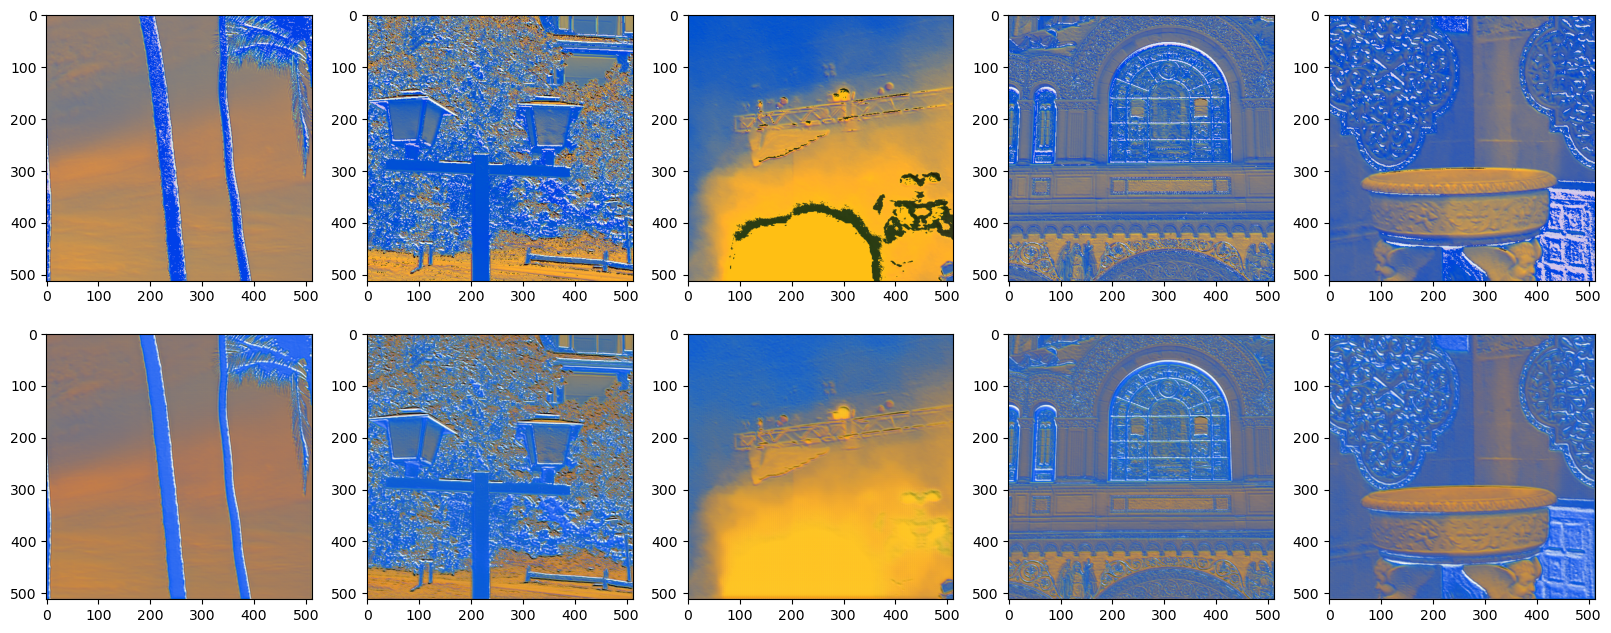

In [49]:
Images = Data.Test_labels[0:5]

plt.figure(figsize=(20, 20))
files = 10
for i in range(files):
    plt.subplot(5, 5, i+1)
    if i < 5:
        img = Image.open(Images[i])
        plt.imshow(img)
    else:
        img = predictions[0][i-5].permute(1, 2, 0).numpy()

        plt.imshow(np.clip(img, 0.0, 1.0))
#         plt.axis('off')  # Turn off axis labels and ticks
#         plt.show()